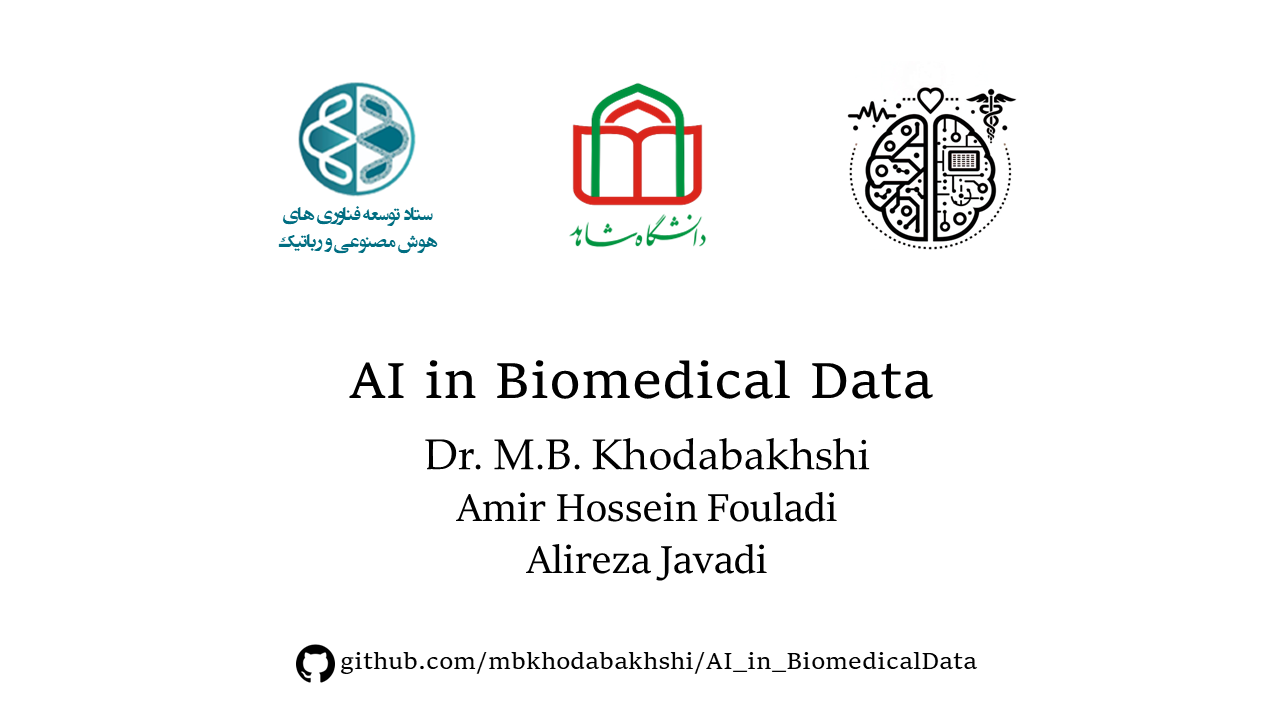

# Unsupervised Learning for Liver Lesion Segmentation in CT Images

Unsupervised learning is a type of machine learning technique used to identify patterns or structures in data without the need for labeled examples. Liver lesion segmentation in CT images is a critical task in medical imaging, aimed at identifying and delineating abnormal tissue regions within the liver. Accurate segmentation can assist in diagnosis, treatment planning, and monitoring of liver diseases, such as cancer.


# Liver Segmentation 3D-IRCADb Dataset

The **3D-IRCADb-01** dataset is a valuable resource for liver segmentation research, featuring 3D CT scans from 20 patients (10 women and 10 men), with hepatic tumors present in 75% of cases. This dataset aids in the development and evaluation of segmentation algorithms by providing diverse and annotated medical imaging data.

## Access the Dataset

The dataset is openly accessible and can be downloaded from the following link: [3D-IRCADb-01 Dataset](https://www.ircad.fr/research/data-sets/liver-segmentation-3d-ircadb-01/).

# Needed Library

## [Pydicom Library](https://pydicom.github.io/)

Pydicom is a Python library for working with DICOM files, the standard format for medical images. It allows you to easily read, modify, and write these files.

# Creating a 3D Volume from DICOM Slices

DICOM files for medical scans are stored as separate slices in 3Dircad dataset. To analyze, we need to combine these slices into a 3D volume. This process helps in getting a complete view of the area being studied. While you can work with individual slices, creating a 3D volume offers a more comprehensive understanding.

In [1]:
import os
import SimpleITK as sitk
import pydicom
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_dicom_images_from_folder(folder_path):
    dicom_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    dicom_files.sort(key=lambda f: int(''.join(filter(str.isdigit, os.path.basename(f)))))
    return dicom_files

def read_dicom_series(dicom_files):
    slices = [pydicom.dcmread(f) for f in dicom_files]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return slices

def convert_to_volume(dicom_files):
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(dicom_files)
    image = reader.Execute()
    return image

def load_volume(folder_path):
    dicom_files = load_dicom_images_from_folder(folder_path)
    slices = read_dicom_series(dicom_files)
    volume = convert_to_volume(dicom_files)
    return sitk.GetArrayFromImage(volume)

def get_tumor_folders(main_directory):
    tumor_folders = [os.path.join(main_directory, folder) for folder in os.listdir(main_directory) if folder.startswith('livertumor')]
    return tumor_folders

def sum_tumor_volumes(tumor_volumes):
    combined_array = sitk.GetArrayFromImage(tumor_volumes[0])

    for volume in tumor_volumes[1:]:
        volume_array = sitk.GetArrayFromImage(volume)
        combined_array += volume_array

    combined_volume = sitk.GetImageFromArray(combined_array)
    combined_volume.CopyInformation(tumor_volumes[0])

    return combined_volume

def load_and_sum_tumors(main_directory):
    tumor_folders = get_tumor_folders(main_directory)
    tumor_volumes = []

    for folder in tumor_folders:
        dicom_files = load_dicom_images_from_folder(folder)
        tumor_volume = convert_to_volume(dicom_files)
        tumor_volumes.append(tumor_volume)

    combined_volume = sum_tumor_volumes(tumor_volumes)
    return sitk.GetArrayFromImage(combined_volume)


In [3]:
ct_volume = load_volume("E:\\3Dircadb\\3Dircadb1.1\\PATIENT_DICOM")

liver_mask_volume = load_volume("E:\\3Dircadb\\3Dircadb1.1\\liver")

tumors_mask_volume = load_and_sum_tumors("E:\\3Dircadb\\3Dircadb1.1")

In [4]:
print(f"Combined volume size: {tumors_mask_volume.shape}")

Combined volume size: (129, 512, 512)


# Data Visualization

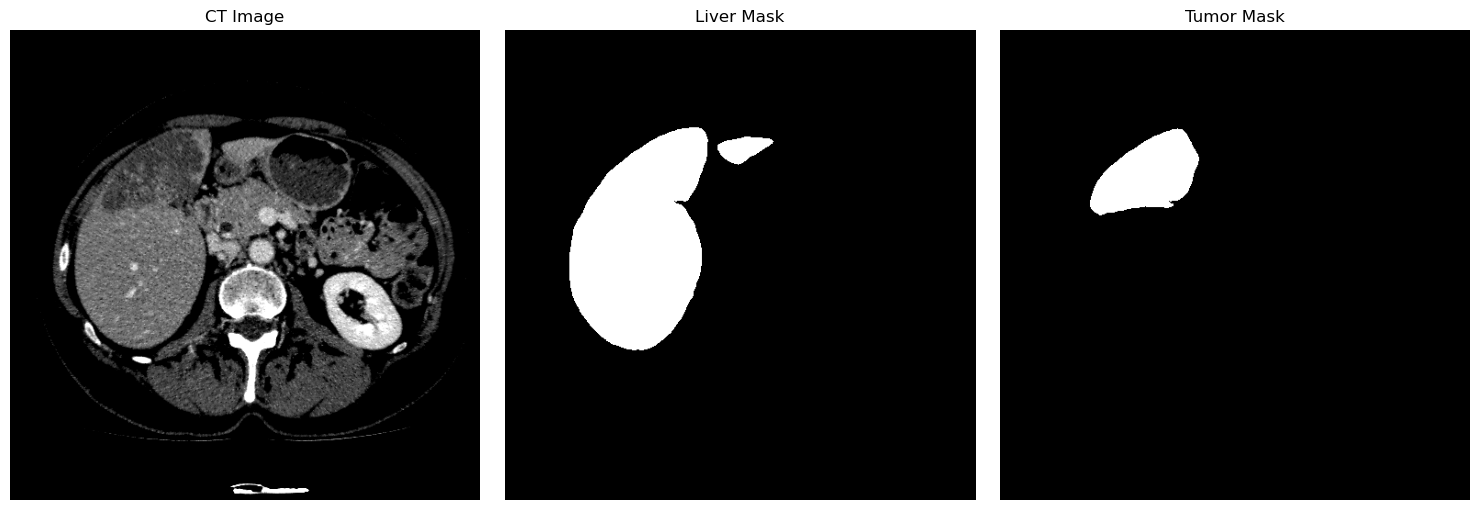

In [8]:
plt.figure(figsize=(15, 5))

# CT Image
plt.subplot(1, 3, 1)
plt.imshow(ct_volume[60, :, :], cmap='gray')
plt.title("CT Image")
plt.axis("off")

# Liver Mask
plt.subplot(1, 3, 2)
plt.imshow(liver_mask_volume[60, :, :], cmap='gray')
plt.title("Liver Mask")
plt.axis("off")

# Tumor Mask
plt.subplot(1, 3, 3)
plt.imshow(tumors_mask_volume[60, :, :], cmap='gray')
plt.title("Tumor Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


# Preprocessing

In [5]:
print(f"Minimum intensity in CT image is: {np.min(ct_volume)}, and the maximum intensity is: {np.max(ct_volume)}")
print(f"Unique values of liver mask are: {np.unique(liver_mask_volume)} and unique values of tumor mask are: {np.unique(tumors_mask_volume)}")

ct_volume = np.clip(ct_volume, 0, 255)
liver_mask_volume = liver_mask_volume / 255
tumors_mask_volume = tumors_mask_volume / 255
print("-"*100)
print(f"New minimum intensity in CT image is: {np.min(ct_volume)}, and new maximum intensity is: {np.max(ct_volume)}")
print(f"New unique values of liver mask are: {np.unique(liver_mask_volume)} and new unique values of tumor mask are: {np.unique(tumors_mask_volume)}")

Minimum intensity in CT image is: -1024, and the maximum intensity is: 1023
Unique values of liver mask are: [  0 255] and unique values of tumor mask are: [  0 255]
----------------------------------------------------------------------------------------------------
New minimum intensity in CT image is: 0, and new maximum intensity is: 255
New unique values of liver mask are: [0. 1.] and new unique values of tumor mask are: [0. 1.]


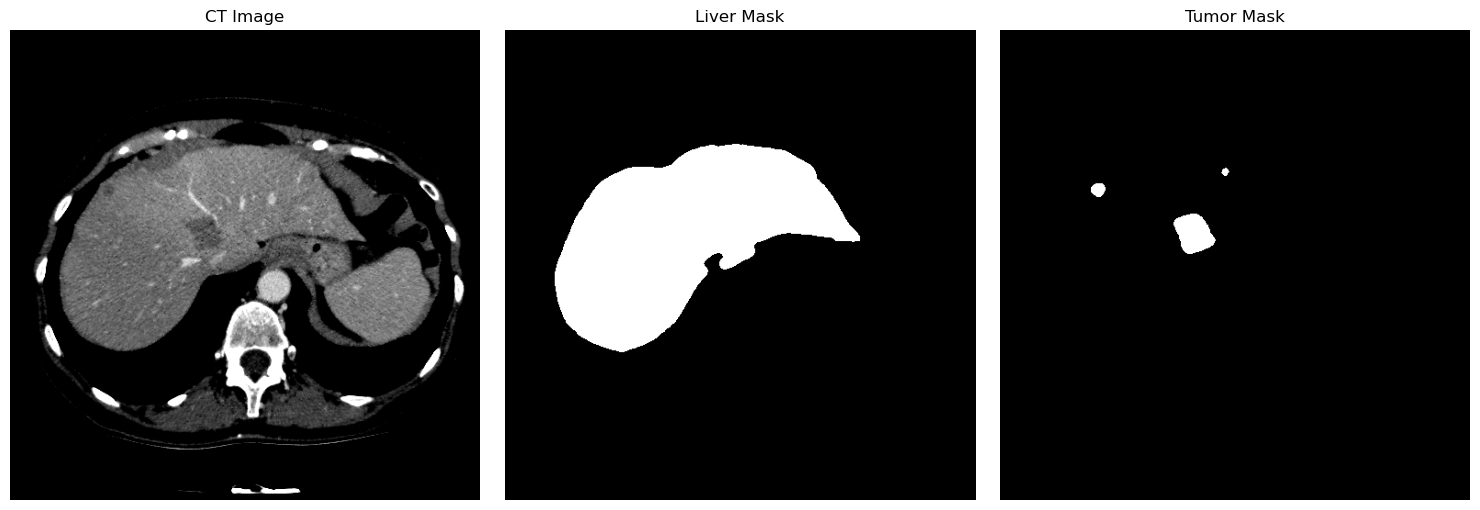

In [45]:
plt.figure(figsize=(15, 5))

# CT Image
plt.subplot(1, 3, 1)
plt.imshow(ct_volume[110, :, :], cmap='gray')
plt.title("CT Image")
plt.axis("off")

# Liver Mask
plt.subplot(1, 3, 2)
plt.imshow(liver_mask_volume[110, :, :], cmap='gray')
plt.title("Liver Mask")
plt.axis("off")

# Tumor Mask
plt.subplot(1, 3, 3)
plt.imshow(tumors_mask_volume[110, :, :], cmap='gray')
plt.title("Tumor Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


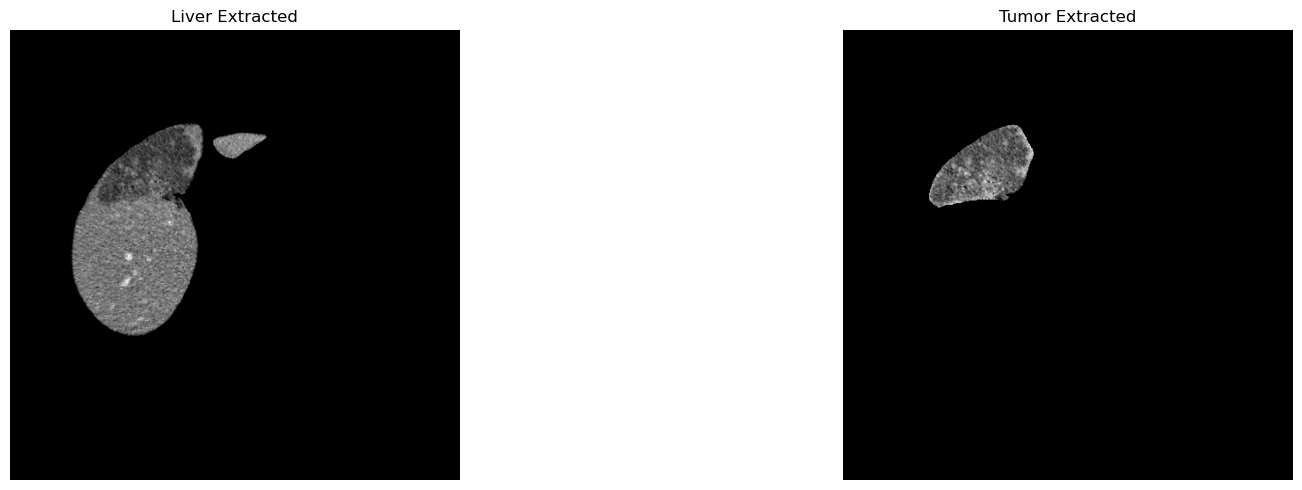

In [8]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)

plt.imshow(ct_volume[60, :, :] * liver_mask_volume[60, :, :], cmap='gray')
plt.title("Liver Extracted")
plt.axis("off")


plt.subplot(1, 2, 2)

plt.imshow(ct_volume[60, :, :] * tumors_mask_volume[60, :, :], cmap='gray')
plt.title("Tumor Extracted")
plt.axis("off")


plt.tight_layout()
plt.show()

# KMeans Clustering

KMeans is an unsupervised learning algorithm that groups data into K clusters based on similarity. It works by assigning data points to the nearest cluster center and updating these centers until the clusters stabilize.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score, f1_score
from skimage.morphology import dilation, erosion, disk, square


## Assigning variables

In [10]:
ct = ct_volume[60, :, :]


liver_mask = liver_mask_volume[60, :, :]


tumor_mask = tumors_mask_volume[60, :, :]



liver_extracted_ct = ct * liver_mask


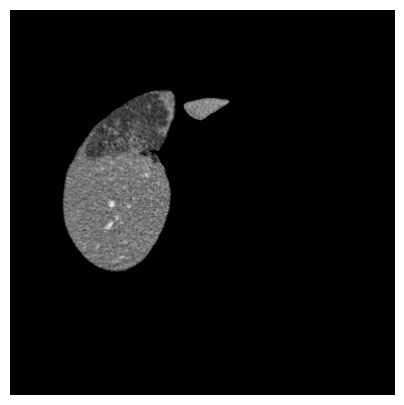

In [11]:
plt.figure(figsize=(5, 5))

plt.imshow(liver_extracted_ct, cmap='gray')
plt.axis("off")
plt.show()

## Apply KMeans for Tumor Segmentation

In [12]:
from sklearn.preprocessing import StandardScaler

liver_pixels = liver_extracted_ct[liver_mask > 0]
liver_pixels = liver_pixels.reshape(-1, 1)

scaler = StandardScaler()
liver_pixels_scaled = scaler.fit_transform(liver_pixels)

k = 2


kmeans = KMeans(n_clusters=k,n_init=10, random_state=42)
kmeans.fit(liver_pixels_scaled)
labels = kmeans.predict(liver_pixels_scaled)

clustered_image = np.zeros(liver_extracted_ct.shape, dtype=int)
clustered_image[liver_mask > 0] = labels

## KMeans Clusters Visualization

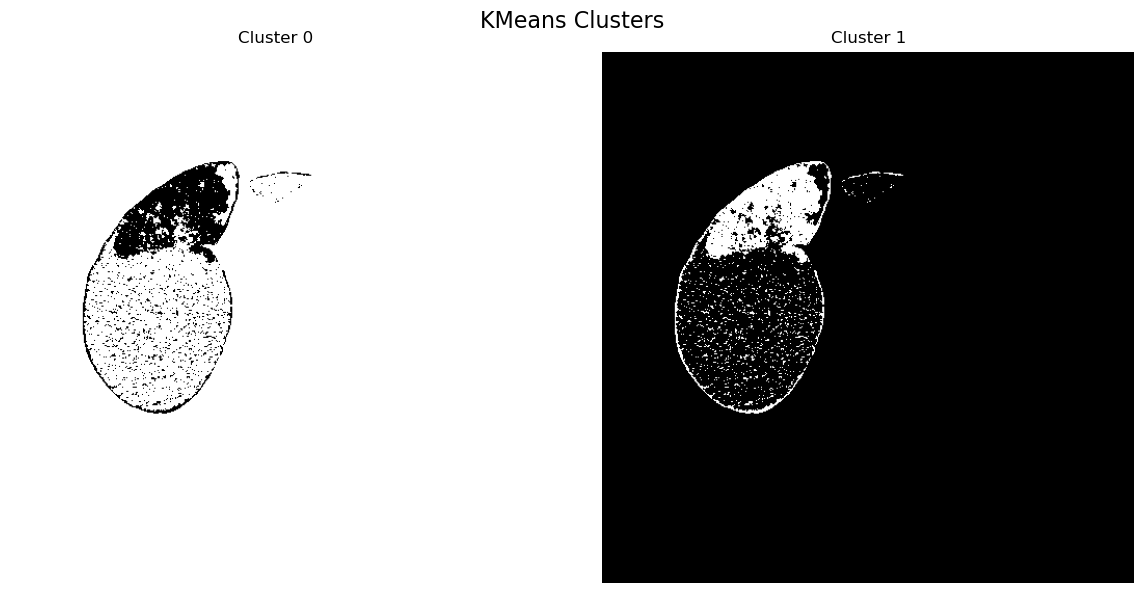

In [13]:
unique_clusters = np.unique(labels)
num_clusters = len(unique_clusters)


plt.figure(figsize=(12, 6))
for i in range(num_clusters):
    plt.subplot(1, num_clusters, i + 1)

    mask = clustered_image == i
    plt.imshow(mask, cmap='gray')
    plt.title(f'Cluster {i}')
    plt.axis('off')

plt.suptitle('KMeans Clusters', fontsize=16)
plt.tight_layout()
plt.show()


## Selecting the Optimal Number of Clusters with Silhouette Score

The silhouette score is a valuable metric for assessing the quality of clustering results. It quantifies how well each data point fits within its assigned cluster, balancing cohesion (how close the points in a cluster are to each other) and separation (how distinct a cluster is from others). A higher silhouette score indicates better-defined clusters, helping you choose the optimal number of clusters (K) for your data.

Evaluating and plotting clusters and silhouette diagrams for different k values...
K=2, Silhouette Score: 0.619


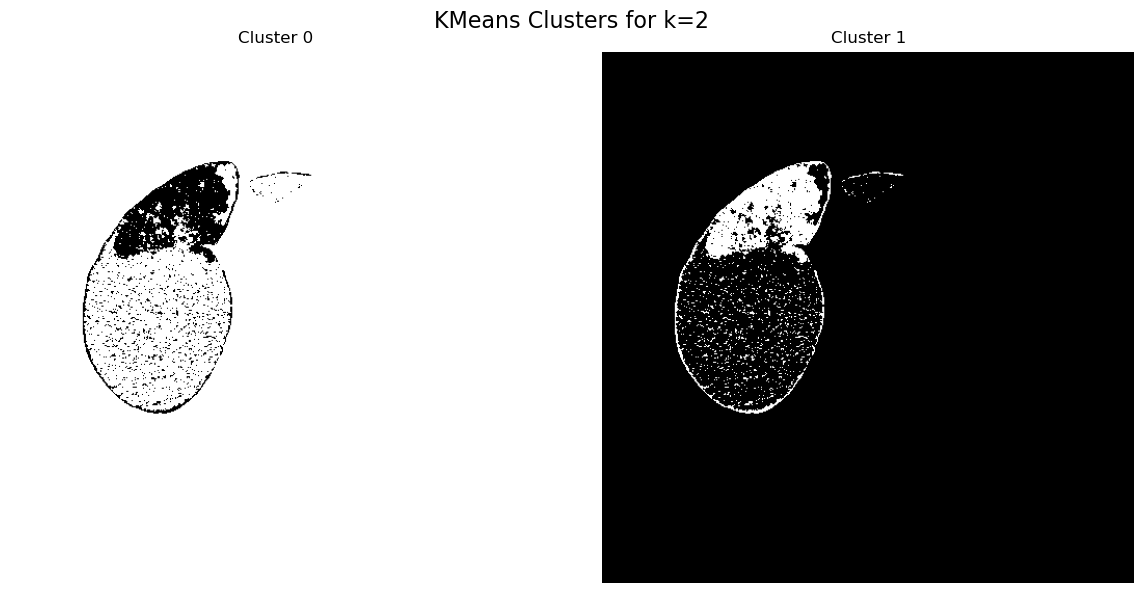

K=3, Silhouette Score: 0.536


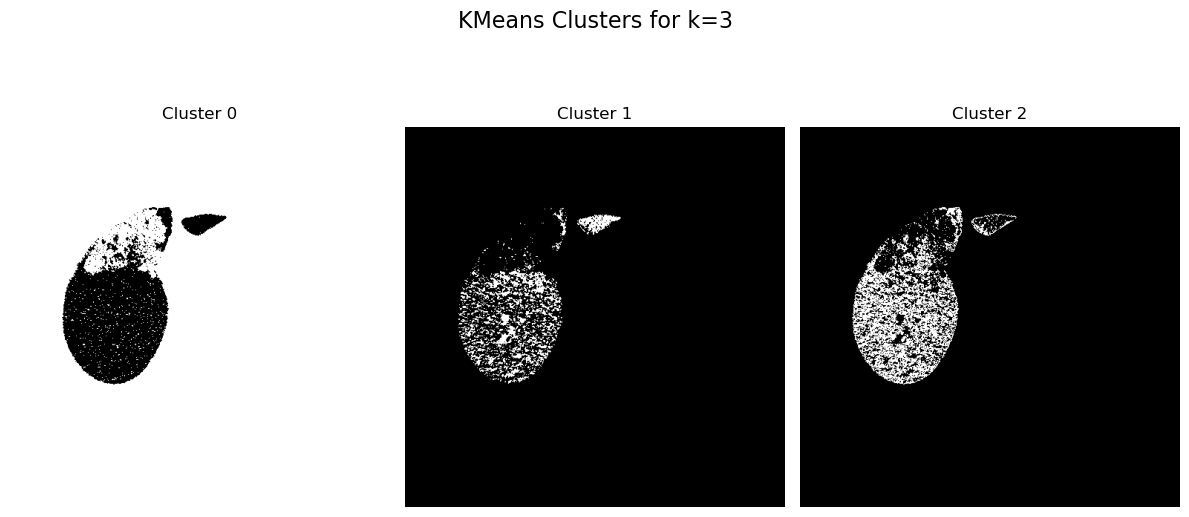

K=4, Silhouette Score: 0.526


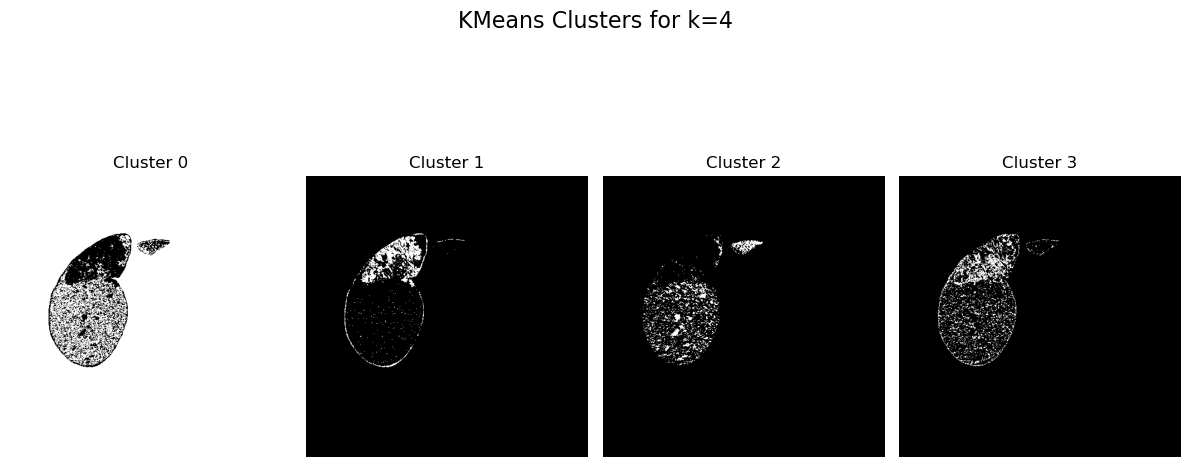

K=5, Silhouette Score: 0.513


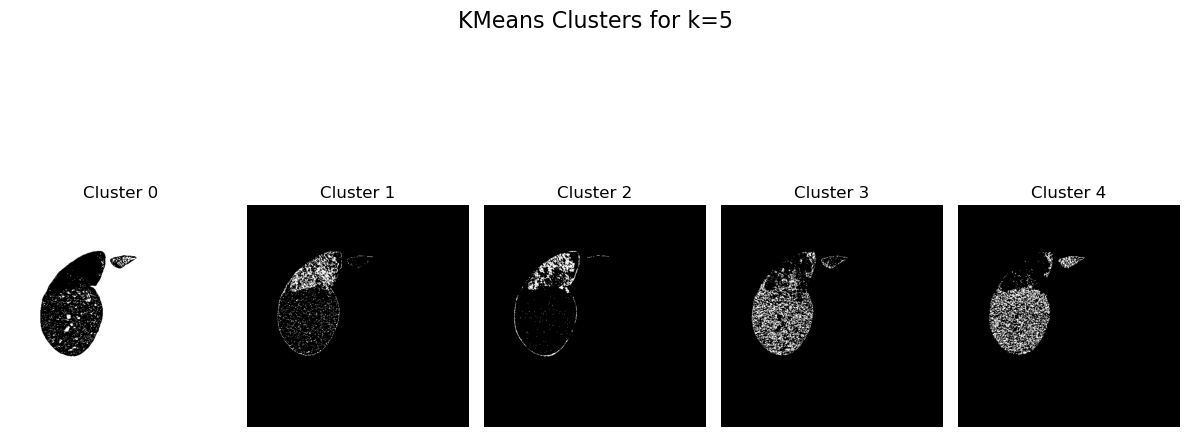

K=6, Silhouette Score: 0.520


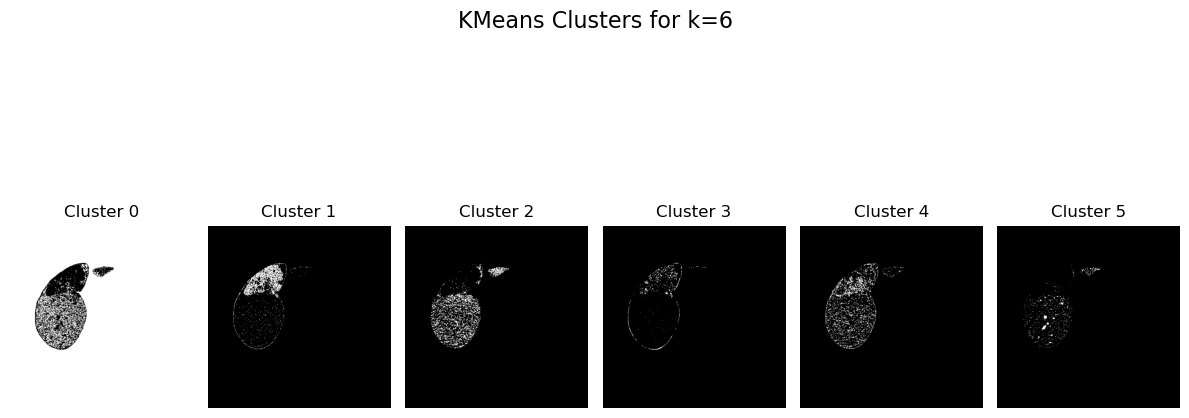

K=7, Silhouette Score: 0.519


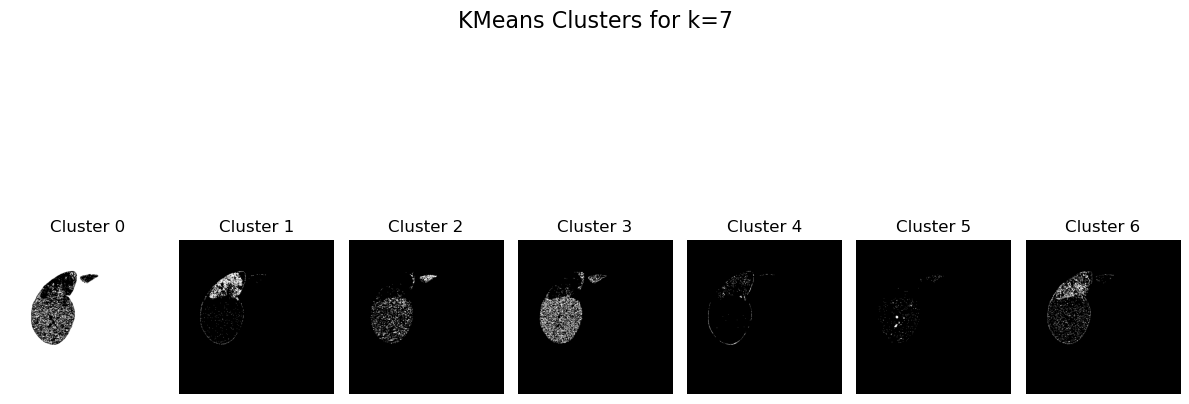

K=8, Silhouette Score: 0.523


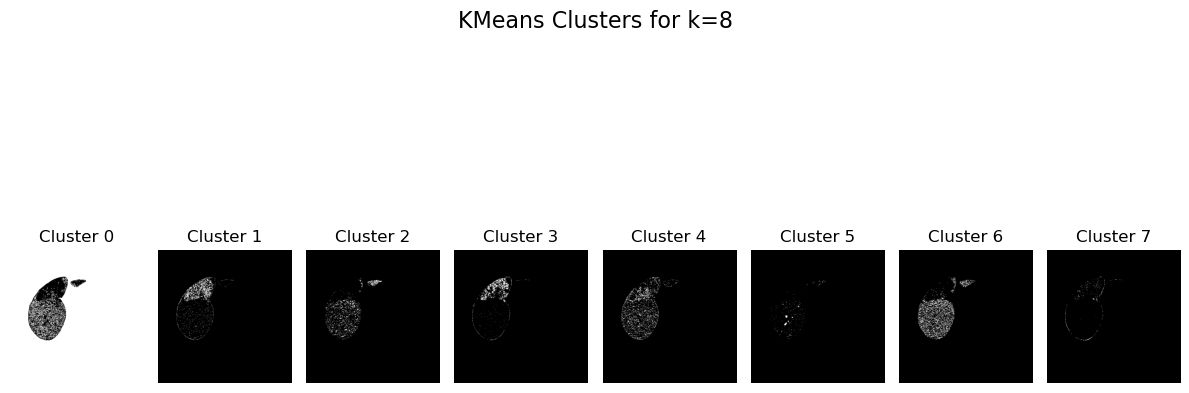

K=9, Silhouette Score: 0.519


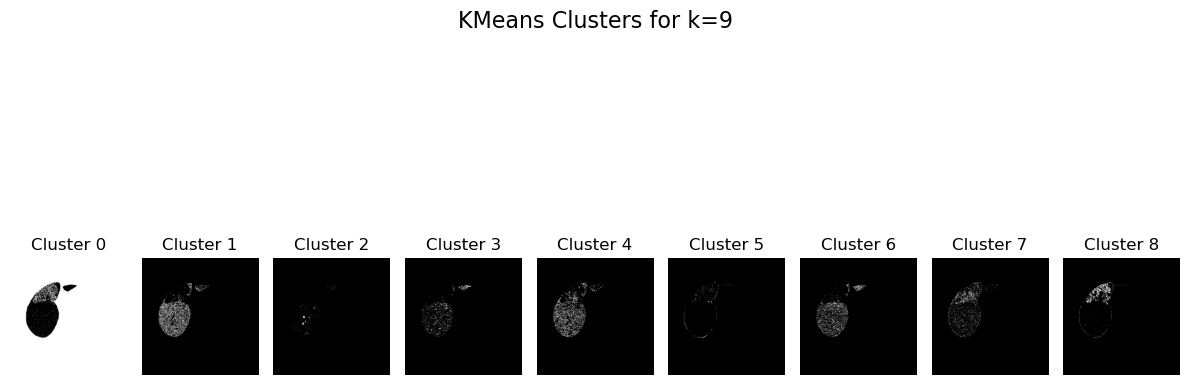

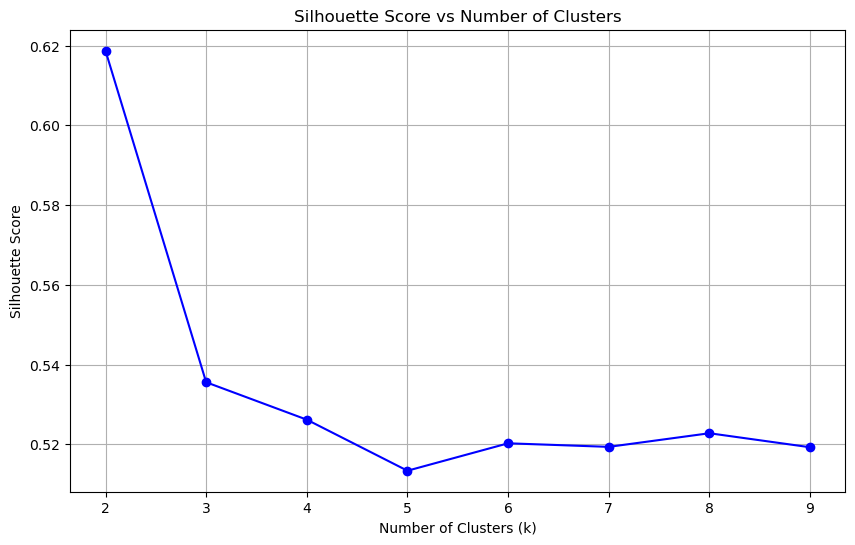


Best number of clusters (k) based on silhouette score: 2
Best silhouette score: 0.619


In [17]:
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle

sample_size = 50000
n_pixels = liver_pixels_scaled.shape[0]


indices = shuffle(np.arange(n_pixels), random_state=42)[:sample_size]
pixels_sample = liver_pixels_scaled[indices]


silhouette_scores = []
best_score = -1
best_k = None
best_labels = None

print("Evaluating and plotting clusters and silhouette diagrams for different k values...")
for k in range(2, 10):

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(liver_pixels_scaled)


    sample_labels = kmeans.predict(pixels_sample)
    score = silhouette_score(pixels_sample, sample_labels)
    silhouette_scores.append(score)

    print(f"K={k}, Silhouette Score: {score:.3f}")

    if score > best_score:
        best_score = score
        best_k = k
        best_kmeans = kmeans


    labels = kmeans.labels_
    clustered_image = np.zeros(liver_extracted_ct.shape, dtype=int)
    clustered_image[liver_mask > 0] = labels

    unique_clusters = np.unique(labels)
    num_clusters = len(unique_clusters)

    plt.figure(figsize=(12, 6))
    for i in range(num_clusters):
        plt.subplot(1, num_clusters, i + 1)
        mask = clustered_image == i
        plt.imshow(mask, cmap='gray')
        plt.title(f'Cluster {i}')
        plt.axis('off')

    plt.suptitle(f'KMeans Clusters for k={k}', fontsize=16)
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

print(f"\nBest number of clusters (k) based on silhouette score: {best_k}")
print(f"Best silhouette score: {best_score:.3f}")

## Selecting Cluster with Minimum Pixels

In [18]:
labels = best_kmeans.predict(liver_pixels_scaled)

clustered_image = np.zeros(liver_extracted_ct.shape, dtype=int)
clustered_image[liver_mask > 0] = labels

pixel_counts = np.bincount(labels)


min_cluster_id = np.argmin(pixel_counts)
min_cluster_count = pixel_counts[min_cluster_id]

print(f"Cluster {min_cluster_id} has the minimum number of pixels: {min_cluster_count}")


Cluster 1 has the minimum number of pixels: 8317


## Extract and Visualize the Selected Cluster Mask

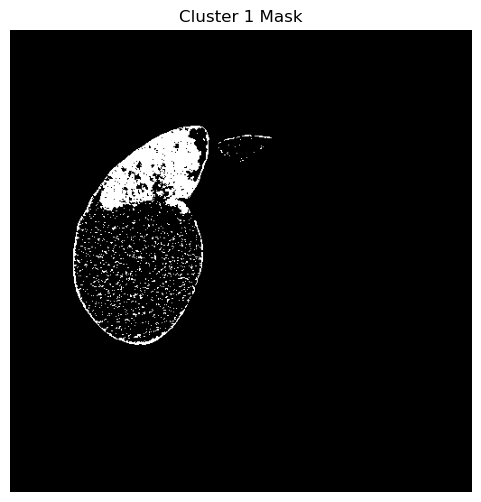

In [20]:
min_cluster_mask = (clustered_image == min_cluster_id)

plt.figure(figsize=(6, 6))
plt.imshow(min_cluster_mask, cmap='gray')
plt.title(f'Cluster {min_cluster_id} Mask')
plt.axis('off')
plt.show()


## Post-processing: Erosion and Dilation

Erosion and dilation are fundamental morphological operations used in image processing to refine and enhance binary images.

- **Erosion**: This operation removes pixels on object boundaries, effectively shrinking objects in the image. It is useful for eliminating small noise and separating connected objects.

- **Dilation**: This operation adds pixels to the boundaries of objects, expanding them. It helps in closing small gaps and connecting disjointed parts of an object.

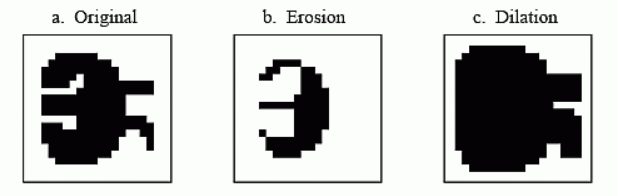


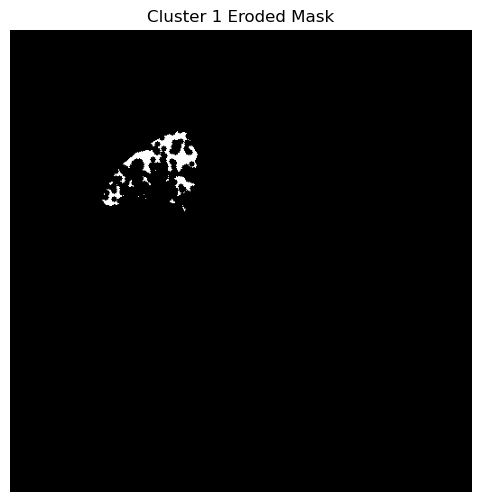

In [22]:
structuring_element = disk(3)

eroded_mask = erosion(min_cluster_mask, structuring_element)

plt.figure(figsize=(6, 6))
plt.imshow(eroded_mask, cmap='gray')
plt.title(f'Cluster {min_cluster_id} Eroded Mask')
plt.axis('off')
plt.show()


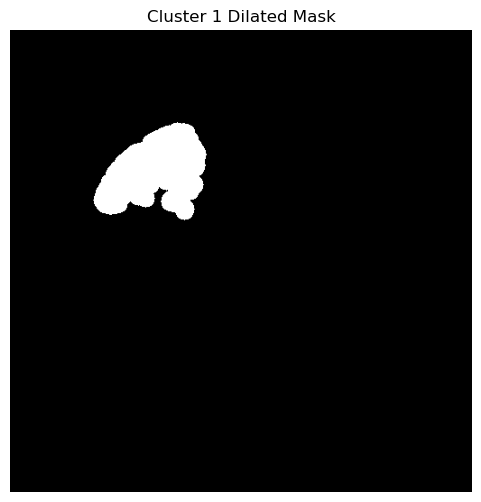

In [23]:
structuring_element = disk(10)
dilated_mask = dilation(eroded_mask, structuring_element)

plt.figure(figsize=(6, 6))
plt.imshow(dilated_mask, cmap='gray')
plt.title(f'Cluster {min_cluster_id} Dilated Mask')
plt.axis('off')
plt.show()


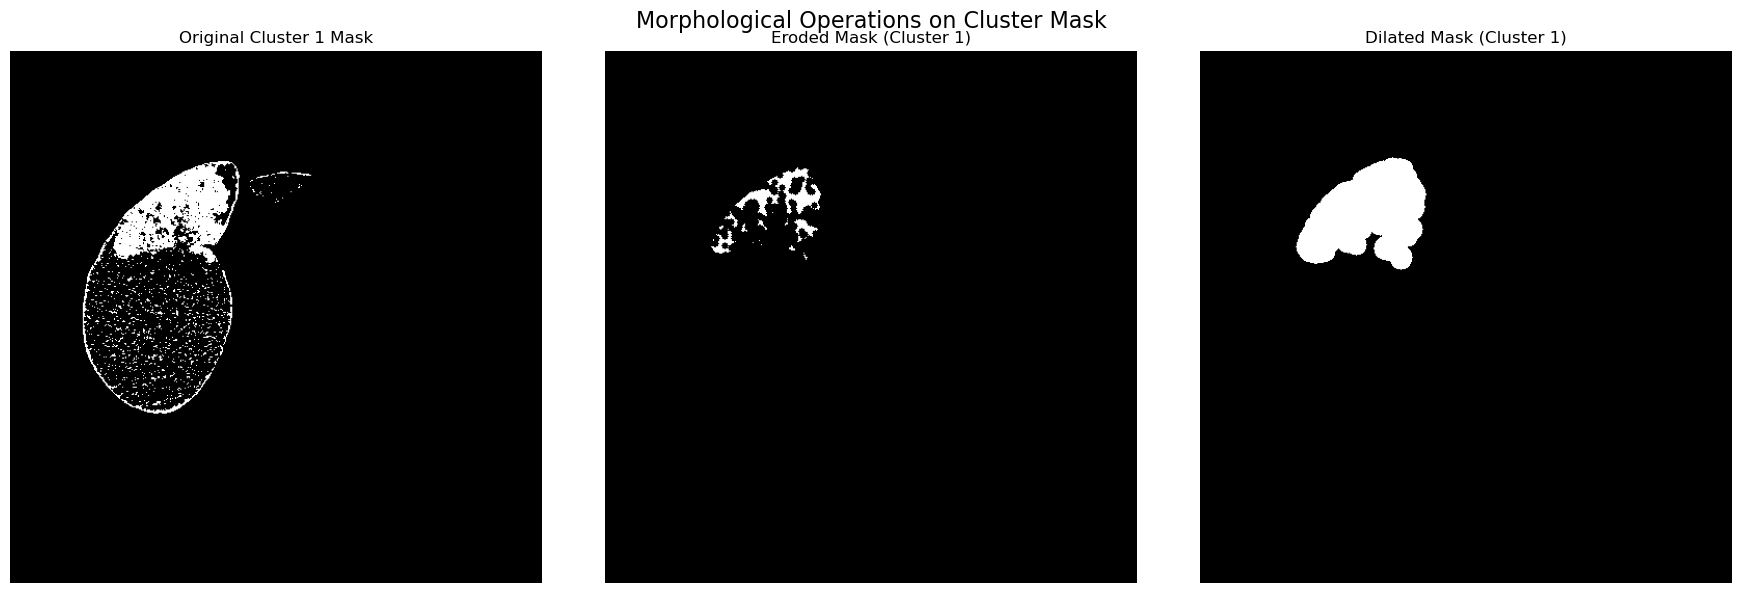

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


axes[0].imshow(min_cluster_mask, cmap='gray')
axes[0].set_title(f'Original Cluster {min_cluster_id} Mask')
axes[0].axis('off')


axes[1].imshow(eroded_mask, cmap='gray')
axes[1].set_title(f'Eroded Mask (Cluster {min_cluster_id})')
axes[1].axis('off')


axes[2].imshow(dilated_mask, cmap='gray')
axes[2].set_title(f'Dilated Mask (Cluster {min_cluster_id})')
axes[2].axis('off')

plt.suptitle('Morphological Operations on Cluster Mask', fontsize=16)
plt.tight_layout()
plt.show()


## Evaluation Metrics: IoU and Dice Coefficient

When assessing the performance of image segmentation models, two widely used metrics are Intersection over Union (IoU) and Dice Coefficient. These metrics provide insights into how accurately the predicted segmentation matches the ground truth.

- **Intersection over Union (IoU)**: Also known as the Jaccard Index, IoU measures the overlap between the predicted segmentation and the ground truth.

- **Dice Coefficient**: Similar to IoU, the Dice Coefficient evaluates the similarity between two sets.

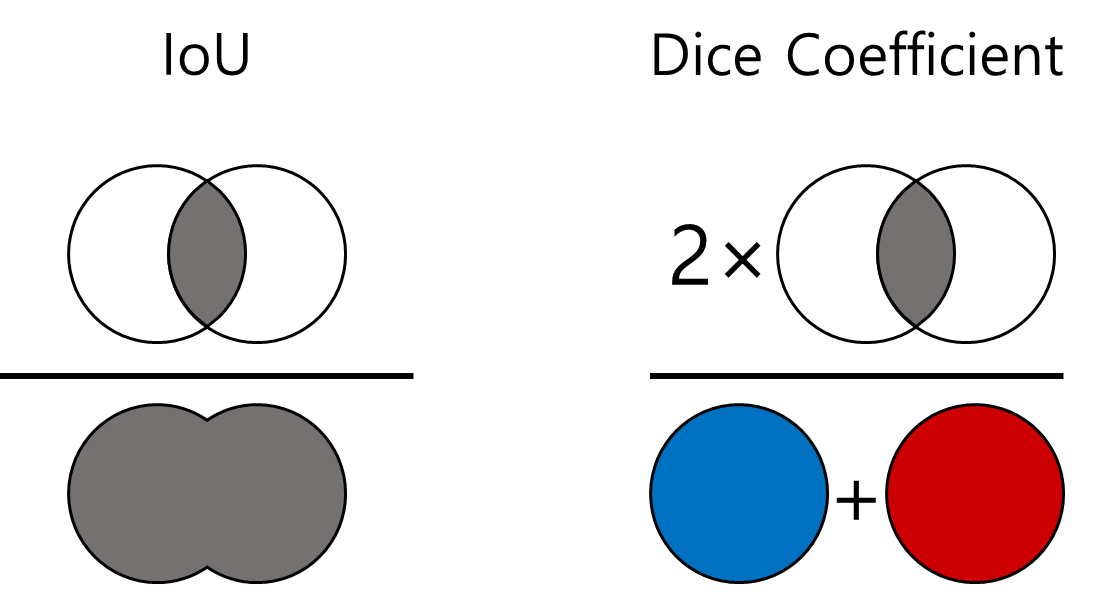

In [24]:
predicted_flat = dilated_mask.flatten()
ground_truth_flat = tumor_mask.flatten()


iou = jaccard_score(ground_truth_flat, predicted_flat)


dice = f1_score(ground_truth_flat, predicted_flat)


print(f"\nEvaluation Metrics for Tumor Segmentation:")
print(f"Intersection over Union (IoU): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")



Evaluation Metrics for Tumor Segmentation:
Intersection over Union (IoU): 0.7747
Dice Coefficient: 0.8730


## Segmentation Results on Original Image Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


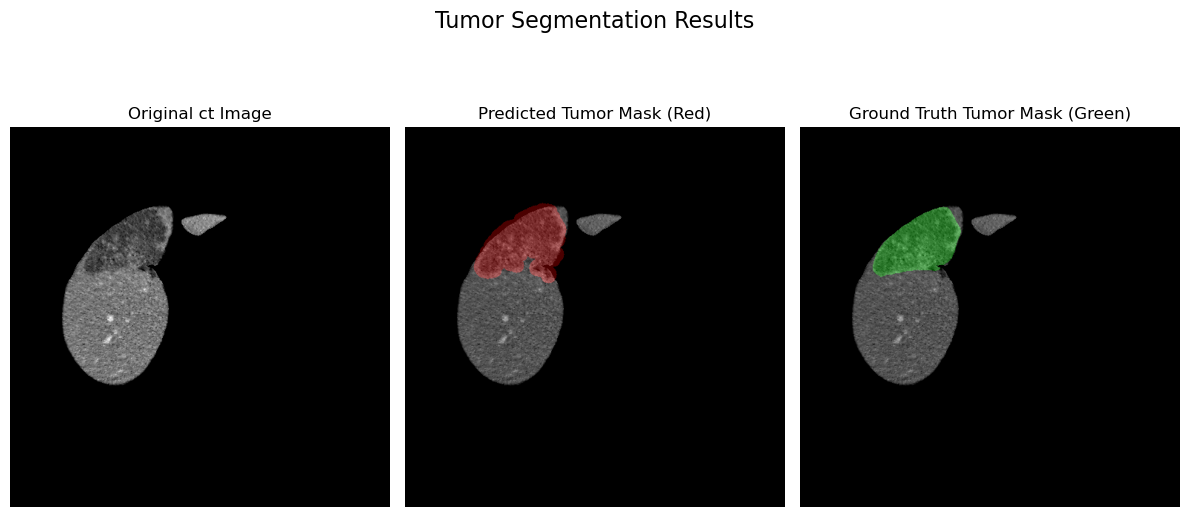

In [26]:
ct_rgb = np.stack([liver_extracted_ct]*3, axis=-1)


predicted_overlay = np.zeros_like(ct_rgb)
ground_truth_overlay = np.zeros_like(ct_rgb)


predicted_overlay[dilated_mask == 1] = [255, 0, 0]
ground_truth_overlay[tumor_mask == 1] = [0, 255, 0]


combined_overlay = ct_rgb.copy()
combined_overlay = np.where(predicted_overlay.any(axis=-1, keepdims=True), predicted_overlay, combined_overlay)
combined_overlay = np.where(ground_truth_overlay.any(axis=-1, keepdims=True), ground_truth_overlay, combined_overlay)


plt.figure(figsize=(12, 6))


plt.subplot(1, 3, 1)
plt.imshow(liver_extracted_ct, cmap='gray')
plt.title('Original ct Image')
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(liver_extracted_ct, cmap='gray')
plt.imshow(predicted_overlay, alpha=0.3)
plt.title('Predicted Tumor Mask (Red)')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(liver_extracted_ct, cmap='gray')
plt.imshow(ground_truth_overlay, alpha=0.3)
plt.title('Ground Truth Tumor Mask (Green)')
plt.axis('off')

plt.suptitle('Tumor Segmentation Results', fontsize=16)
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Evaluation Metrics for Tumor Segmentation:
Intersection over Union (IoU): 0.8747
Dice Coefficient: 0.9332


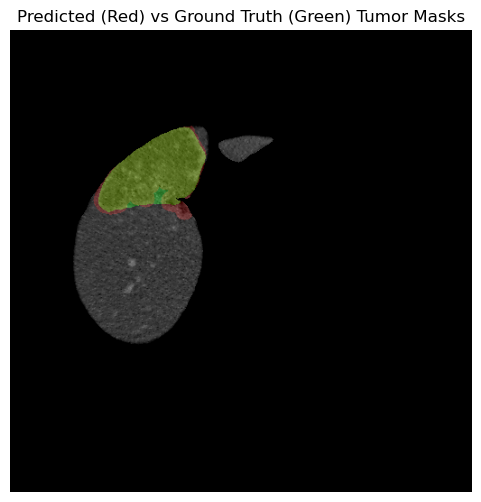

In [27]:
predicted_tumor_mask = np.logical_and(dilated_mask, liver_mask)
predicted_overlay = np.zeros_like(ct_rgb)
predicted_overlay[predicted_tumor_mask == 1] = [255, 0, 0]
combined_overlay = np.where(predicted_overlay.any(axis=-1, keepdims=True), predicted_overlay, combined_overlay)

predicted_flat = predicted_tumor_mask.flatten()
ground_truth_flat = tumor_mask.flatten()


iou = jaccard_score(ground_truth_flat, predicted_flat)


dice = f1_score(ground_truth_flat, predicted_flat)


print(f"\nEvaluation Metrics for Tumor Segmentation:")
print(f"Intersection over Union (IoU): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")

plt.figure(figsize=(6, 6))
plt.imshow(liver_extracted_ct, cmap='gray')
plt.imshow(predicted_overlay, alpha=0.3)
plt.imshow(ground_truth_overlay, alpha=0.3)
plt.title('Predicted (Red) vs Ground Truth (Green) Tumor Masks')
plt.axis('off')
plt.show()

# DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups data based on density. It identifies clusters of varying shapes and sizes without needing to specify the number of clusters beforehand. DBSCAN also detects noise or outliers, making it useful for spatial data analysis.

In [28]:
from sklearn.cluster import DBSCAN

## Apply DBSCAN for Tumor Segmentation

In [29]:
dbscan = DBSCAN(eps=0.07, min_samples=950, metric="l2")
labels = dbscan.fit_predict(liver_pixels_scaled)

db_cluster_image = np.zeros(liver_extracted_ct.shape, dtype=int)
db_cluster_image[liver_mask > 0] = labels

## DBSCAN Clusters Visualization

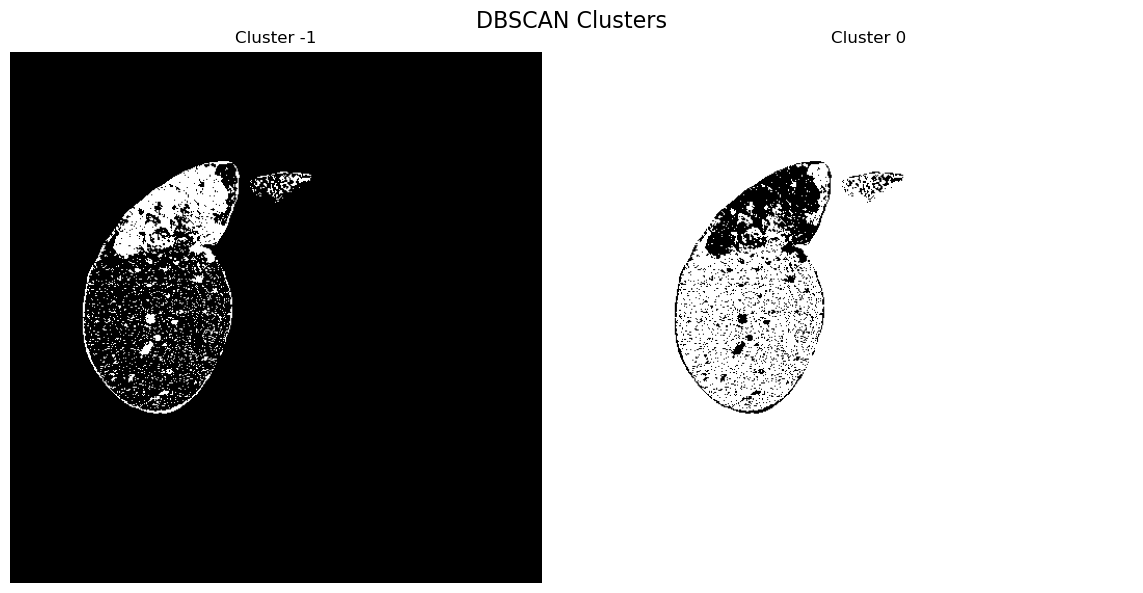

In [30]:
unique_clusters = np.unique(labels)
num_clusters = len(unique_clusters)


plt.figure(figsize=(12, 6))
for i in range(num_clusters):
    plt.subplot(1, num_clusters, i + 1)

    
    mask = db_cluster_image == unique_clusters[i]
    plt.imshow(mask, cmap='gray')
    plt.title(f'Cluster {unique_clusters[i]}')
    plt.axis('off')

plt.suptitle('DBSCAN Clusters', fontsize=16)
plt.tight_layout()
plt.show()

## Extract and Visualize the Selected Cluster Mask

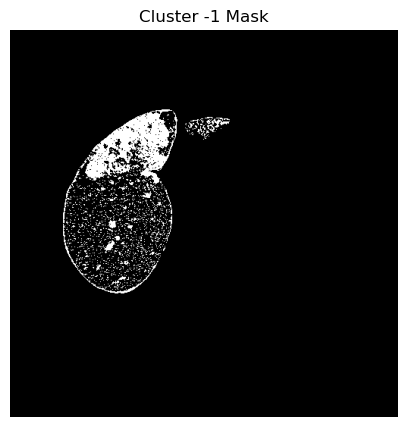

In [31]:
selected_cluster_mask = (db_cluster_image == -1)


plt.figure(figsize=(5, 10))
plt.imshow(selected_cluster_mask, cmap="gray")
plt.title(f'Cluster {-1} Mask')
plt.axis('off')
plt.show()

## Post-processing: Erosion and Dilation

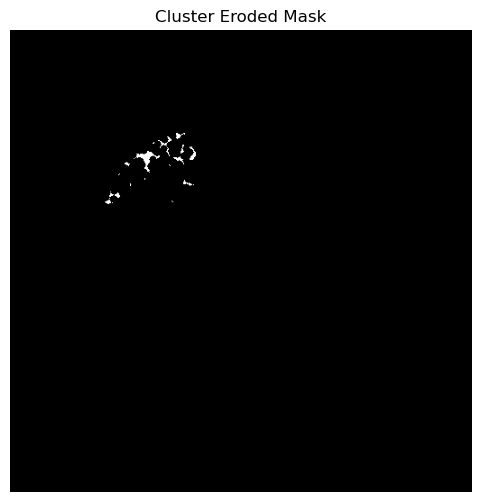

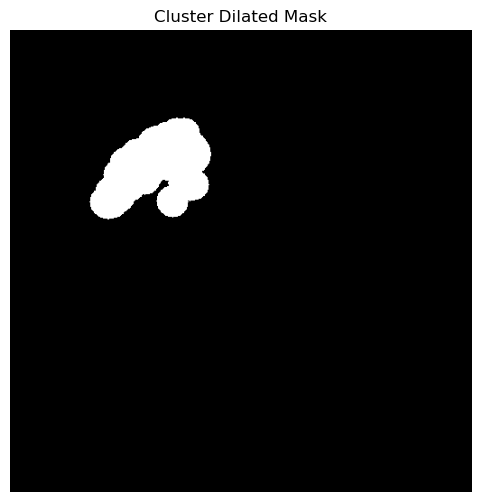

In [33]:
structuring_element = disk(4)


eroded_mask = erosion(selected_cluster_mask, structuring_element)


plt.figure(figsize=(6, 6))
plt.imshow(eroded_mask, cmap='gray')
plt.title(f'Cluster Eroded Mask')
plt.axis('off')
plt.show()




structuring_element = disk(17)
dilated_mask = dilation(eroded_mask, structuring_element)


plt.figure(figsize=(6, 6))
plt.imshow(dilated_mask, cmap='gray')
plt.title(f'Cluster Dilated Mask')
plt.axis('off')
plt.show()

## Evaluation Metrics: IoU and Dice Coefficient

In [34]:
predicted_tumor_mask = np.logical_and(dilated_mask, liver_mask)

predicted_flat = predicted_tumor_mask.flatten()
ground_truth_flat = tumor_mask.flatten()


iou = jaccard_score(ground_truth_flat, predicted_flat)


dice = f1_score(ground_truth_flat, predicted_flat)



print(f"\nEvaluation Metrics for Tumor clustered_image:")
print(f"Intersection over Union (IoU): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")



Evaluation Metrics for Tumor clustered_image:
Intersection over Union (IoU): 0.8091
Dice Coefficient: 0.8945


## Segmentation Results on Original Image Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


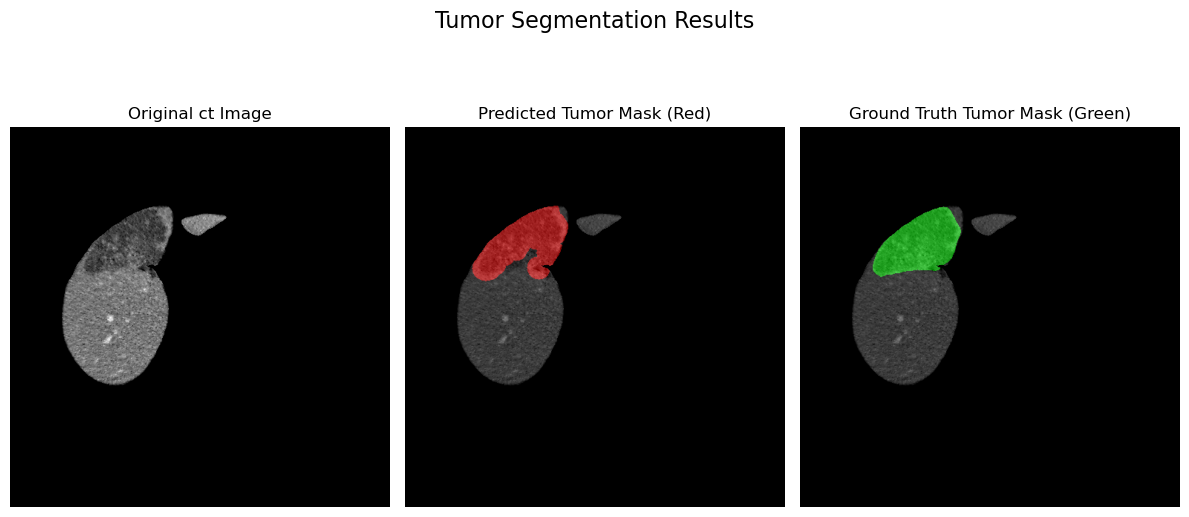

In [29]:
ct_rgb = np.stack([liver_extracted_ct]*3, axis=-1)


predicted_overlay = np.zeros_like(ct_rgb)
ground_truth_overlay = np.zeros_like(ct_rgb)


predicted_overlay[predicted_tumor_mask == 1] = [255, 0, 0]  # Red
ground_truth_overlay[tumor_mask == 1] = [0, 255, 0]  # Green


combined_overlay = ct_rgb.copy()
combined_overlay = np.where(predicted_overlay.any(axis=-1, keepdims=True), predicted_overlay, combined_overlay)
combined_overlay = np.where(ground_truth_overlay.any(axis=-1, keepdims=True), ground_truth_overlay, combined_overlay)


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(liver_extracted_ct, cmap='gray')
plt.title('Original ct Image')
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(liver_extracted_ct, cmap='gray')
plt.imshow(predicted_overlay, alpha=0.5)  # Red overlay
plt.title('Predicted Tumor Mask (Red)')
plt.axis('off')



plt.subplot(1, 3, 3)
plt.imshow(liver_extracted_ct, cmap='gray')
plt.imshow(ground_truth_overlay, alpha=0.5)  # Green overlay
plt.title('Ground Truth Tumor Mask (Green)')
plt.axis('off')

plt.suptitle('Tumor Segmentation Results', fontsize=16)
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


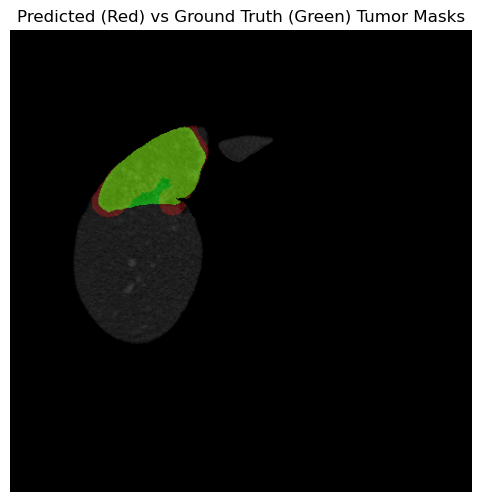

In [30]:
plt.figure(figsize=(6, 6))
plt.imshow(liver_extracted_ct, cmap='gray')
plt.imshow(predicted_overlay, alpha=0.5)  # Red for predicted
plt.imshow(ground_truth_overlay, alpha=0.5)  # Green for ground truth
plt.title('Predicted (Red) vs Ground Truth (Green) Tumor Masks')
plt.axis('off')
plt.show()

# Gaussian Mixture Models (GMM)

Gaussian Mixture Models (GMM) cluster data by modeling it as a combination of multiple Gaussian distributions. Each cluster is a Gaussian with its own mean and variance, allowing for flexible, overlapping clusters.

In [35]:
from sklearn.mixture import GaussianMixture

## Apply GMM for Tumor Segmentation

In [36]:
n_components = 2
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(liver_pixels_scaled)

labels = gmm.predict(liver_pixels_scaled)

gmm_cluster_image = np.zeros(liver_extracted_ct.shape, dtype=int)
gmm_cluster_image[liver_mask > 0] = labels

## GMM Clusters Visualization

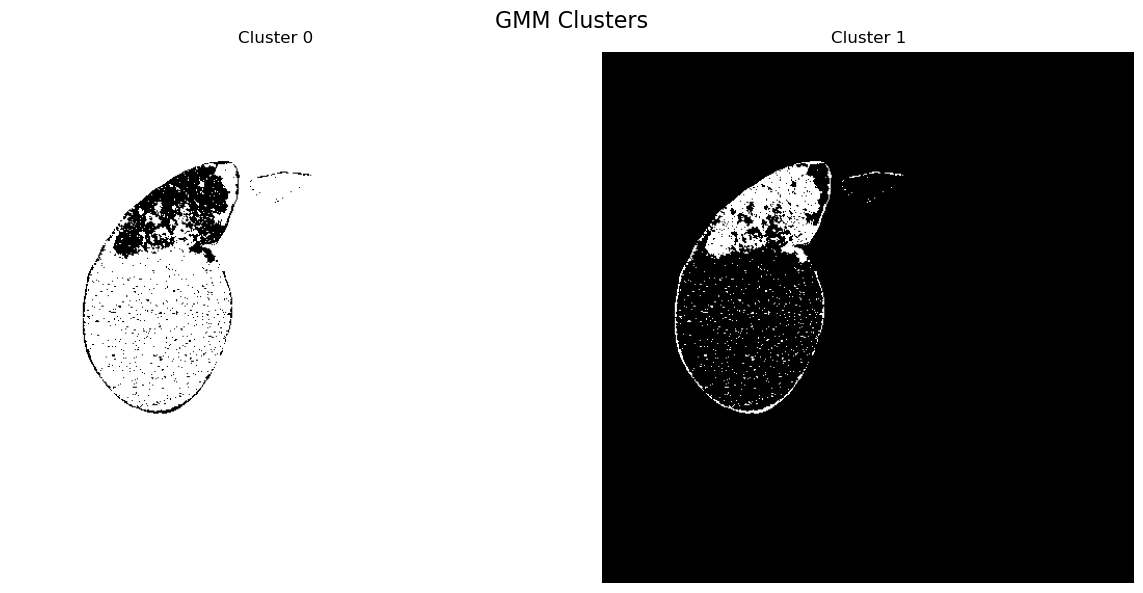

In [37]:
unique_clusters = np.unique(labels)
num_clusters = len(unique_clusters)


plt.figure(figsize=(12, 6))
for i in range(num_clusters):
    plt.subplot(1, num_clusters, i + 1)

    
    mask = gmm_cluster_image == unique_clusters[i]
    plt.imshow(mask, cmap='gray')
    plt.title(f'Cluster {unique_clusters[i]}')
    plt.axis('off')

plt.suptitle('GMM Clusters', fontsize=16)
plt.tight_layout()
plt.show()

## Extract and Visualize the Selected Cluster Mask

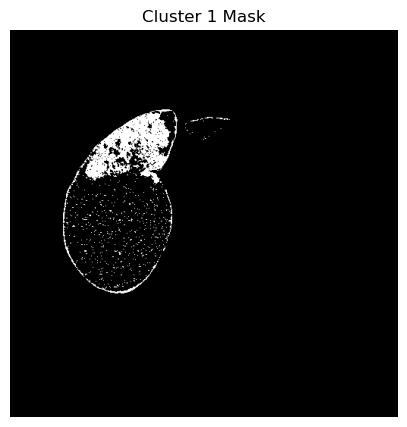

In [38]:
selected_cluster_mask = (gmm_cluster_image == 1)

plt.figure(figsize=(5, 10))
plt.imshow(selected_cluster_mask, cmap="gray")
plt.title(f'Cluster {1} Mask')
plt.axis('off')
plt.show()

## Post-processing: Erosion and Dilation

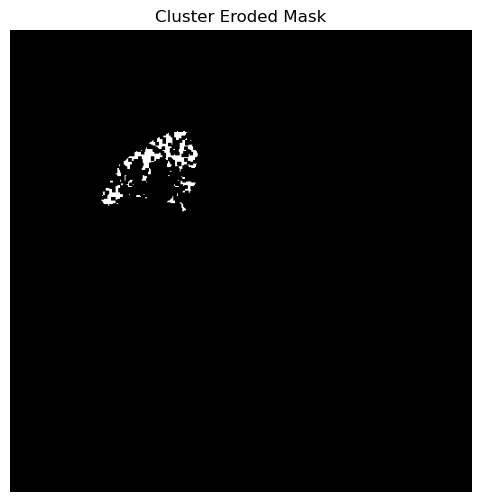

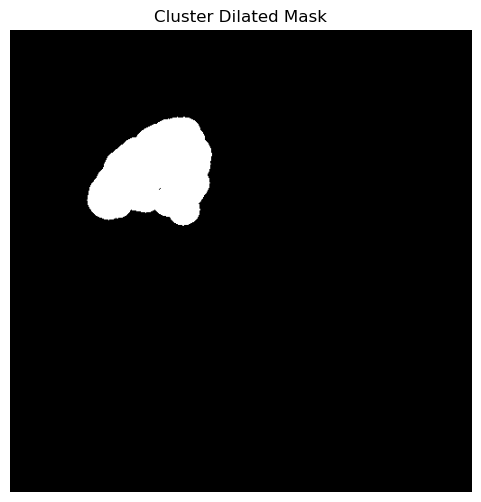

In [40]:
structuring_element = square(4)


eroded_mask = erosion(selected_cluster_mask, structuring_element)


plt.figure(figsize=(6, 6))
plt.imshow(eroded_mask, cmap='gray')
plt.title(f'Cluster Eroded Mask')
plt.axis('off')
plt.show()




structuring_element = disk(16)
dilated_mask = dilation(eroded_mask, structuring_element)


plt.figure(figsize=(6, 6))
plt.imshow(dilated_mask, cmap='gray')
plt.title(f'Cluster Dilated Mask')
plt.axis('off')
plt.show()

## Evaluation Metrics: IoU and Dice Coefficient

In [41]:
predicted_tumor_mask = np.logical_and(dilated_mask, liver_mask)

predicted_flat = predicted_tumor_mask.flatten()
ground_truth_flat = tumor_mask.flatten()


iou = jaccard_score(ground_truth_flat, predicted_flat)


dice = f1_score(ground_truth_flat, predicted_flat)



print(f"\nEvaluation Metrics for Tumor Segmentation:")
print(f"Intersection over Union (IoU): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")



Evaluation Metrics for Tumor Segmentation:
Intersection over Union (IoU): 0.7939
Dice Coefficient: 0.8851


## Segmentation Results on Original Image Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


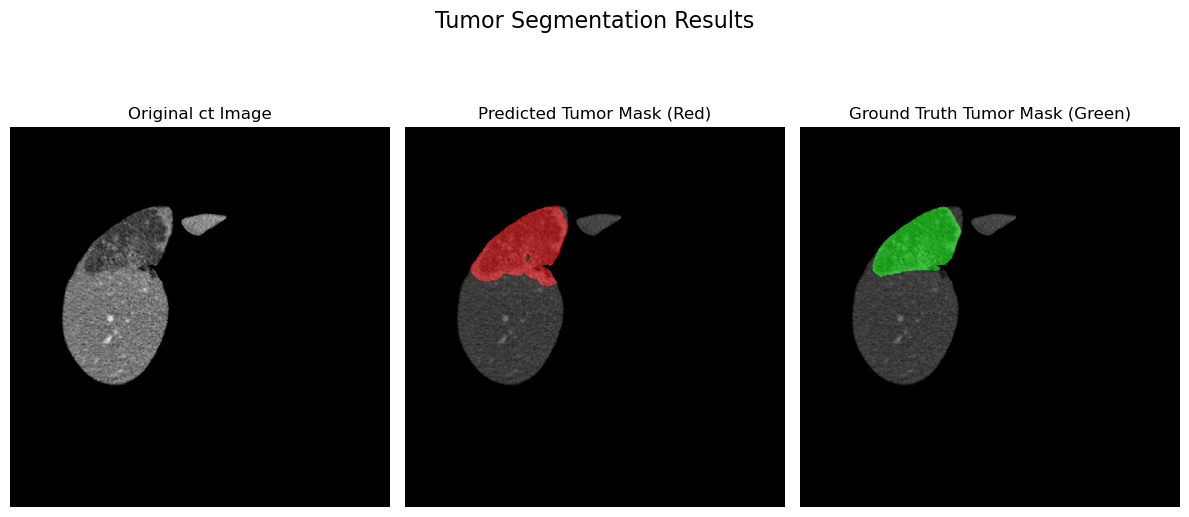

In [37]:
ct_rgb = np.stack([liver_extracted_ct]*3, axis=-1)


predicted_overlay = np.zeros_like(ct_rgb)
ground_truth_overlay = np.zeros_like(ct_rgb)


predicted_overlay[predicted_tumor_mask == 1] = [255, 0, 0]  # Red
ground_truth_overlay[tumor_mask == 1] = [0, 255, 0]  # Green


combined_overlay = ct_rgb.copy()
combined_overlay = np.where(predicted_overlay.any(axis=-1, keepdims=True), predicted_overlay, combined_overlay)
combined_overlay = np.where(ground_truth_overlay.any(axis=-1, keepdims=True), ground_truth_overlay, combined_overlay)


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(liver_extracted_ct, cmap='gray')
plt.title('Original ct Image')
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(liver_extracted_ct, cmap='gray')
plt.imshow(predicted_overlay, alpha=0.5)  # Red overlay
plt.title('Predicted Tumor Mask (Red)')
plt.axis('off')



plt.subplot(1, 3, 3)
plt.imshow(liver_extracted_ct, cmap='gray')
plt.imshow(ground_truth_overlay, alpha=0.5)  # Green overlay
plt.title('Ground Truth Tumor Mask (Green)')
plt.axis('off')

plt.suptitle('Tumor Segmentation Results', fontsize=16)
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


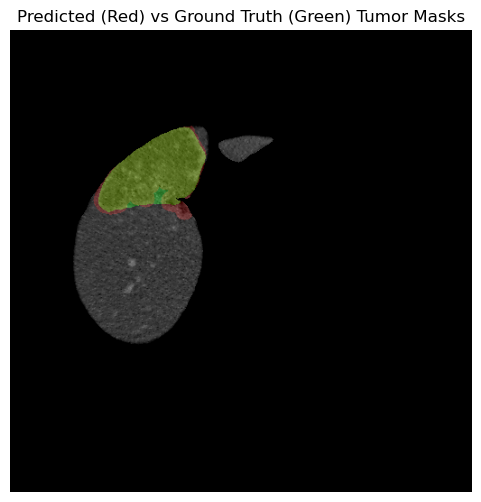

In [42]:
plt.figure(figsize=(6, 6))
plt.imshow(liver_extracted_ct, cmap='gray')
plt.imshow(predicted_overlay, alpha=0.3)  # Red for predicted
plt.imshow(ground_truth_overlay, alpha=0.3)  # Green for ground truth
plt.title('Predicted (Red) vs Ground Truth (Green) Tumor Masks')
plt.axis('off')
plt.show()